In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import beta
import timeit
from scipy.interpolate import interp1d
import scipy.stats as st

# The true distribution
We take the true distribution of $y$ to be $\mathcal{Beta}(3,3)$ drawn on $[-1,1]$. i.e. we have unormalized density
<br>
<center> $(1+y)^2(1-y)^2$

We seek to find $x^*$ such that it solves $\min_x E[c(x,y)]$ where
<br>
<center>$c(x,y) = 3x^2 + 6xy^2 - 2x^2y - 7xy$.

This can be solved analytically, whereby $x$ is minimised at $-1/7$ = -0.14286.

Text(0.5,1,'True Distribution of Y')

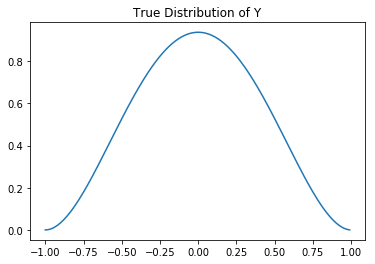

In [2]:
# Define the true distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)

# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)
plt.title("True Distribution of Y")

In [3]:
# the cost function we would like to minimise
def f(x,y, weights=None,find_mean=True,):
    function = 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y
    if find_mean:
        if weights is not None:
            return np.average(function,axis=0,weights=weights)
        else:
            return np.mean(function,axis=0)
    else:
        return function

In [4]:
def SAA_minimise(samples, func, p0=0.0):
    res = minimize(func,p0,args=(samples))
    return res.x

In [5]:
def bayesian_minimise(samples,func,p0=0.0,n_samples=10000):
    # pick n_samples beta distribution from priors
    a_sample = np.random.uniform(alpha_low,alpha_high,n_samples)
    b_sample = np.random.uniform(beta_low,beta_high,n_samples)
    location = np.random.uniform(location_low,location_high,n_samples)
    scale = np.random.uniform(scale_low,scale_high,n_samples)
    
    beta_dist = beta(a_sample,b_sample,location,scale)
    
    # sample each of the betas
    beta_sample = beta_dist.rvs()
    
    # calculate the weights determined by the likelihood
    likelihood = np.prod((beta_dist.pdf(np.reshape(samples,(-1,1)))*4),axis=0)
    
    res = minimize(func,p0,args=(beta_sample,likelihood))
    
    return res.x

In [6]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 10000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [20,50,100,200]

# uniform priors
alpha_low = 2.0
alpha_high = 4.0

beta_low = 2.0
beta_high = 4.0

location_high = -0.8
location_low = -1.2

scale_high = 1.8
scale_low = 2.2

In [7]:
SAA_results = np.zeros((n_iter,len(N)))
bayesian_results = np.zeros((n_iter,len(N)))


start_time = timeit.default_timer()

for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        
        x_star = SAA_minimise(S,f)
        SAA_results[k,j] = x_star
        
        bayesian_results[k,j] = bayesian_minimise(S,f)
        
elapsed = timeit.default_timer() - start_time
print("This has taken %.2f seconds") %elapsed        

This has taken 6440.80 seconds


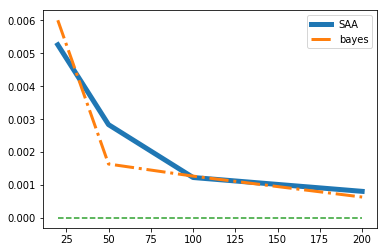

In [8]:
lineObjects = plt.plot(N,np.abs(np.mean(SAA_results,axis=0)+1.0/7),label='SSA approximation',lw=5.0,ls='-')
lineObjects += plt.plot(N,np.abs(np.mean(bayesian_results,axis=0)+1.0/7),ls='-.',lw=3.0)

plt.plot(N,[0.0]*len(N),'--',label='True value')
plt.legend(lineObjects,tuple(['SAA'] + ['bayes'] + ['True value']))

In [10]:
np.savetxt("bayesian.csv", bayesian_results, delimiter=",")